An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

To learn more about autoencoders, please consider reading chapter 14 from Deep Learning by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

In [1]:
#Import TensorFlow and other libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

##  Anomaly detection

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

In [2]:
#Load ECG data
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.tail()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
4993,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,...,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651,0.0
4994,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.234850,-1.593270,-1.075279,-0.976047,...,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612,0.0
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,0.0
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,0.0
4997,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,-0.733839,...,-1.512234,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531,0.0


In [3]:
# The last element contains the labels
labels = raw_data[:, -1] #extracts the last column of the raw_data array

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1] #extracts all columns of the raw_data array except the last one

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [4]:
min_val = tf.reduce_min(train_data) # finding the smallest value among all the features in the training dataset.
max_val = tf.reduce_max(train_data) # finding the largest value among all the features in the training dataset.

#Normalize the data to [0,1].
train_data = (train_data - min_val) / (max_val - min_val) #Each feature value is subtracted by the minimum value (min_val) and then divided by
test_data = (test_data - min_val) / (max_val - min_val)   #the range (max_val - min_val). This ensures that all features are on a similar scale

train_data = tf.cast(train_data, tf.float32)  #data is represented as 32-bit floating-point numbers,
test_data = tf.cast(test_data, tf.float32)    #which is the default data type for many TensorFlow operations

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as 1. Separate the normal rhythms from the abnormal rhythms.

In [5]:
train_labels = train_labels.astype(bool) #convert array to boolean data type to treat labels as binary(normal or anomalous)
test_labels = test_labels.astype(bool)   #normal instance (True or 1) , anomalous instance (False or 0)

normal_train_data = train_data[train_labels] #containing only the instances labeled as True in train_labels. These instances are considered "normal"
normal_test_data = test_data[test_labels]  #containing only the instances labeled as True in test_labels. These instances are considered "normal"

anomalous_train_data = train_data[~train_labels]  #create subsets of the train_data and test_data arrays containing instances labeled as False
anomalous_test_data = test_data[~test_labels] #in train_labels and test_labels, respectively. These instances are considered "anomalous" or abnormal

Plot a normal ECG.

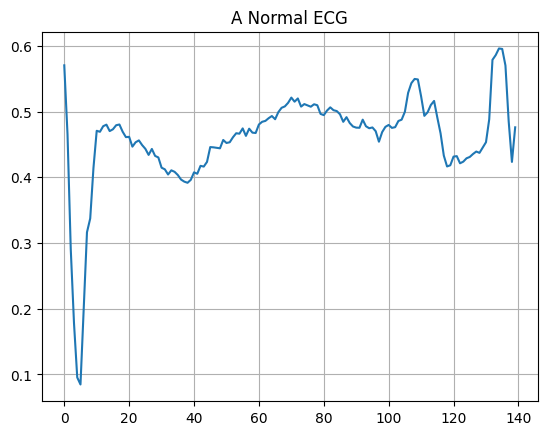

In [6]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
#generates an array from 0 to 139, representing the x-axis values. normal_train_data[0] contains the y-axis values
plt.title("A Normal ECG")
plt.show()

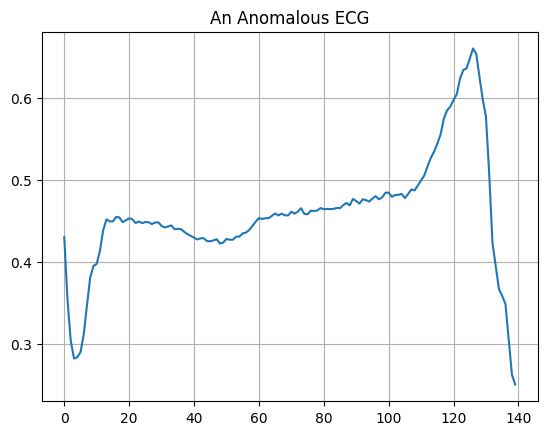

In [7]:
#Plot an anomalous ECG.
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [21]:
#Build the model
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [10]:
autoencoder.compile(optimizer='adam', loss='mae')
# Adaptive Moment Estimation optimization algorithm to be used during training dynamically adjusts the learning rate for each parameter
#Mean Absolute Error loss function bsolute difference between the predicted values and the actual values and then averages these differences

In [ ]:
#Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [11]:
history = autoencoder.fit(normal_train_data, normal_train_data,#input data and target data are same, as model aims to reconstruct the input data
          epochs=20,  # number of times the entire training dataset will be passed forward and backward through the neural network
          batch_size=512,  #model's weights are updated after processing each batch of 512 samples.
          validation_data=(test_data, test_data), #specifies the validation data to be used during training
          shuffle=True) #Indicates that the training data should be shuffled before each epoch

Epoch 1/20
5/5 [==============================] - 2s 60ms/step - loss: 0.0586 - val_loss: 0.0534
Epoch 2/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0562 - val_loss: 0.0517
Epoch 3/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0535 - val_loss: 0.0498
Epoch 4/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0501 - val_loss: 0.0480
Epoch 5/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0462 - val_loss: 0.0464
Epoch 6/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0425 - val_loss: 0.0441
Epoch 7/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0389 - val_loss: 0.0426
Epoch 8/20
5/5 [==============================] - 0s 25ms/step - loss: 0.0357 - val_loss: 0.0412
Epoch 9/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0329 - val_loss: 0.0402
Epoch 10/20
5/5 [==============================] - 0s 23ms/step - loss: 0.0306 - val_loss: 0.0391
Epoch 11/20
5/5 [============

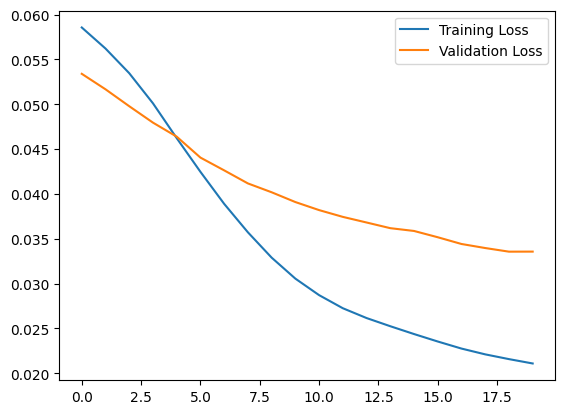

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
#line plots the training loss values,history.history["loss"] contains the training loss values recorded during each epoch
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

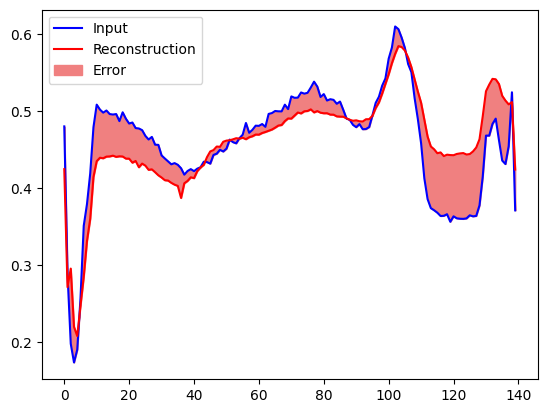

In [13]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
#passes the normal test instances through the encoder part of the autoencoder model and obtains the encoded representations,
#.numpy() method converts the TensorFlow tensor to a NumPy array.

decoded_data = autoencoder.decoder(encoded_data).numpy()
#takes the encoded data and passes it through the decoder part of the autoencoder model to obtain the reconstructed (decoded) data
#.numpy() converts the TensorFlow tensor to a NumPy array

plt.plot(normal_test_data[0], 'b') #plots the original normal test data (input) in blue color
plt.plot(decoded_data[0], 'r')  #plots the reconstructed data (output of the decoder) in red  color.
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
#fills the area betn original data & reconstructed data with a light coral color
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

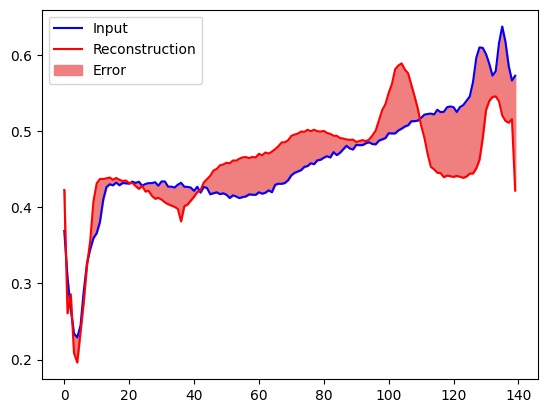

In [14]:
#same as above but is done on anomalous data
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

74/74 [==============================] - 0s 3ms/step


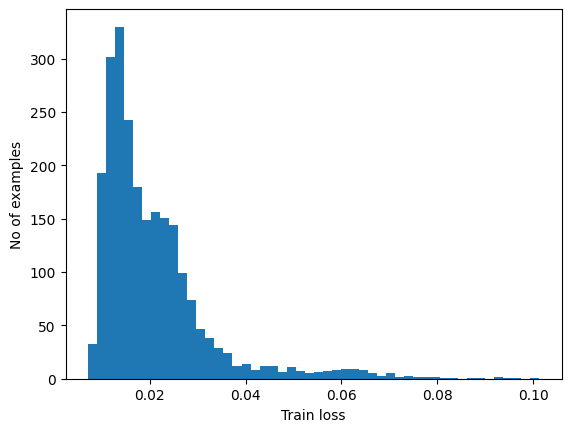

In [15]:
#Plot the reconstruction error on normal ECGs from the training set
reconstructions = autoencoder.predict(normal_train_data)
#line uses the trained autoencoder model to predict the reconstructed data (reconstructions) for the normal training data
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)#mean absolute error loss betn original normal training data & its reconstructions
plt.hist(train_loss[None,:], bins=50) # line creates a histogram of the calculated training loss values
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [16]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)
# calculates the threshold value. np.mean(train_loss) computes the mean of the training loss values, and np.std(train_loss)
# calculates the standard deviation of the training loss values.

Threshold:  0.03285726


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset.

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the precision and recall of your classifier.

14/14 [==============================] - 0s 2ms/step


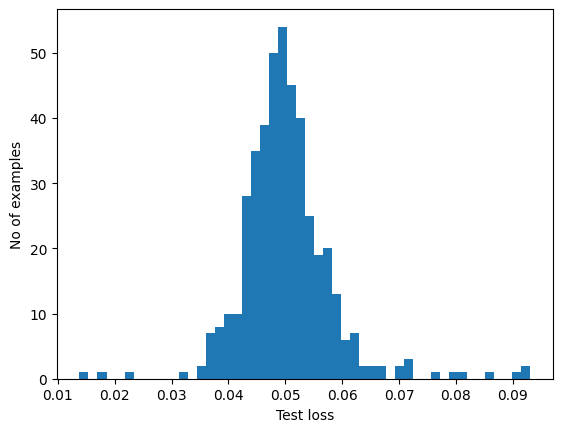

In [17]:
# same as normal data above
reconstructions = autoencoder.predict(anomalous_test_data) #predict the reconstructed data for the anomalous test data
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [18]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)
#predicts the reconstructions using the model, calculates the mean absolute error (MAE) loss between the original data and the reconstructions,
#and compares the loss values with the threshold
#Parameters:
#model: Anomaly detection model (autoencoder in this case).
#data: Input data (either normal or anomalous).
#threshold: Threshold value for classifying anomalies.

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))
#function takes predicted values (predictions) and ground truth labels (labels) and prints accuracy, precision, and recall scores to
#evaluate the model's performance.
#Parameters:
#predictions: Predicted labels indicating anomalies (True) or normals (False).
#labels: Ground truth labels indicating anomalies (True) or normals (False).


In [19]:
preds = predict(autoencoder, train_data, threshold)
print_stats(preds, train_labels)
#calls the predict function with the autoencoder model, training data (train_data), and the calculated threshold.
#It generates predictions for the training data

Accuracy = 0.9377188594297149
Precision = 0.9902416356877324
Recall = 0.9033488766426452


In [20]:
#same as above
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571
